In [7]:
import torch
from torch import nn
import numpy as np
from torch.distributions import Normal, Laplace
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import seaborn as sns

ModuleNotFoundError: No module named 'torch'

In [1]:
from bernstein_transformation_layer import *
from training_helpers import *

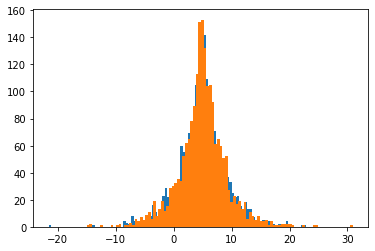

In [2]:
y_distribution = Laplace(5, 3)
y = y_distribution.sample((2000,2)) # Generate training data
plt.hist(y[:,0].numpy(), bins=100)
plt.hist(y[:,1].numpy(), bins=100)
plt.show()

In [4]:
polynomial_range = torch.FloatTensor([[-30, -30],
                                          [40, 40]])
mctm = Transformation(degree=10, number_variables=2, polynomial_range=polynomial_range)

  1%|          | 13/2000 [00:00<00:30, 64.46it/s]

105.03205108642578
102.91436767578125
100.83853912353516
98.80442810058594
96.81196594238281
94.86087799072266
92.95098876953125
91.08195495605469
89.25352478027344
87.46528625488281
85.71686553955078
84.00779724121094
82.33766174316406
80.7059097290039
79.11204528808594
77.55548858642578
76.03567504882812
74.55197143554688


  1%|▏         | 29/2000 [00:00<00:26, 74.10it/s]

73.1037826538086
71.69044494628906
70.31132507324219
68.96572875976562
67.65299224853516
66.3724136352539
65.1233139038086
63.90497589111328
62.71668243408203
61.55775833129883
60.427494049072266
59.3251838684082
58.25013732910156
57.20164489746094
56.179039001464844
55.1816520690918
54.20879364013672


  2%|▏         | 47/2000 [00:00<00:24, 78.47it/s]

53.25981903076172
52.33407974243164
51.430938720703125
50.549774169921875
49.689971923828125
48.85093307495117
48.032073974609375
47.23280715942383
46.45259475708008
45.690879821777344
44.94712829589844
44.220829010009766
43.511478424072266
42.818580627441406
42.14166259765625
41.48025894165039
40.833927154541016


  3%|▎         | 63/2000 [00:00<00:24, 77.76it/s]

40.20222854614258
39.5847282409668
38.98103332519531
38.39073181152344
37.81344223022461
37.24880599975586
36.696434020996094
36.156002044677734
35.62715148925781
35.10956573486328
34.60292434692383
34.106903076171875
33.62123107910156
33.14561080932617
32.67974853515625
32.2234001159668


  4%|▍         | 79/2000 [00:01<00:25, 76.19it/s]

31.776287078857422
31.338157653808594
30.908782958984375
30.48790740966797
30.0753116607666
29.670774459838867
29.27408218383789
28.885025024414062
28.50341033935547
28.1290340423584
27.7617130279541
27.401268005371094
27.047527313232422
26.70030403137207
26.359451293945312


  5%|▍         | 95/2000 [00:01<00:25, 75.75it/s]

26.024797439575195
25.696195602416992
25.373493194580078
25.056543350219727
24.745210647583008
24.439350128173828
24.138837814331055
23.843542098999023
23.553340911865234
23.268110275268555
22.98773956298828
22.712108612060547
22.44110870361328
22.174633026123047
21.912586212158203


  6%|▌         | 112/2000 [00:01<00:24, 76.09it/s]

21.65485954284668
21.401355743408203
21.1519832611084
20.906648635864258
20.665258407592773
20.427736282348633
20.19398307800293
19.963930130004883
19.73749351501465
19.514589309692383
19.29515266418457
19.079099655151367
18.866365432739258
18.656883239746094
18.450576782226562
18.24738883972168


  6%|▋         | 129/2000 [00:01<00:23, 79.04it/s]

18.04724884033203
17.850095748901367
17.655872344970703
17.464513778686523
17.27597427368164
17.090187072753906
16.90709686279297
16.72665786743164
16.548809051513672
16.37350845336914
16.200698852539062
16.03034210205078
15.862381935119629
15.696778297424316
15.53348445892334
15.372454643249512
15.21364974975586


  7%|▋         | 147/2000 [00:01<00:22, 82.44it/s]

15.057025909423828
14.902548789978027
14.750168800354004
14.59985637664795
14.451568603515625
14.305269241333008
14.160924911499023
14.018497467041016
13.877954483032227
13.739262580871582
13.602385520935059
13.467301368713379
13.333964347839355
13.202352523803711
13.072439193725586
12.944184303283691
12.817569732666016
12.692562103271484


  8%|▊         | 165/2000 [00:02<00:22, 81.41it/s]

12.569136619567871
12.447264671325684
12.326918601989746
12.208076477050781
12.09071159362793
11.974801063537598
11.860318183898926
11.747239112854004
11.635544776916504
11.525206565856934
11.416210174560547
11.308526992797852
11.202139854431152
11.097025871276855
10.99316692352295
10.89054012298584
10.789129257202148


  9%|▉         | 183/2000 [00:02<00:21, 82.93it/s]

10.688913345336914
10.589873313903809
10.49199390411377
10.39525318145752
10.299633979797363
10.205121040344238
10.111698150634766
10.019346237182617
9.928049087524414
9.837791442871094
9.74855899810791
9.660333633422852
9.573101997375488
9.486851692199707
9.401561737060547
9.317225456237793
9.2338228225708


 10%|▉         | 192/2000 [00:02<00:21, 82.25it/s]

9.151344299316406
9.06977367401123
8.98909854888916
8.909303665161133
8.830381393432617
8.75231647491455
8.67509937286377
8.598711013793945
8.523146629333496
8.448391914367676
8.374435424804688
8.301263809204102
8.228872299194336
8.157243728637695
8.086370468139648
8.016242027282715
7.946847438812256


 10%|█         | 210/2000 [00:02<00:21, 83.04it/s]

7.878177165985107
7.810220718383789
7.7429680824279785
7.676410675048828
7.610538959503174
7.545343399047852
7.480815887451172
7.41694450378418
7.353725433349609
7.291145324707031
7.229198932647705
7.167875289916992
7.107169151306152
7.047069549560547
6.9875712394714355
6.928663730621338
6.870342254638672
6.812594890594482


 11%|█▏        | 228/2000 [00:02<00:20, 85.63it/s]

6.7554192543029785
6.698805332183838
6.642746925354004
6.587235927581787
6.532266616821289
6.477829933166504
6.423922061920166
6.3705339431762695
6.317661285400391
6.265294551849365
6.213430881500244
6.1620635986328125
6.111184597015381
6.060788631439209
6.010869979858398
5.961421966552734
5.912441730499268
5.863919734954834


 12%|█▏        | 246/2000 [00:03<00:20, 84.47it/s]

5.815852642059326
5.768234729766846
5.721060752868652
5.6743245124816895
5.628019332885742
5.582144737243652
5.536693096160889
5.491658687591553
5.447036266326904
5.402822017669678
5.359010219573975
5.315598964691162
5.272579669952393
5.229950428009033
5.187704563140869
5.145840167999268
5.104351997375488


 13%|█▎        | 264/2000 [00:03<00:20, 82.83it/s]

5.063233852386475
5.022483825683594
4.98209810256958
4.9420695304870605
4.9023966789245605
4.863073348999023
4.824098110198975
4.78546667098999
4.747171878814697
4.709213733673096
4.6715874671936035
4.634288311004639
4.59731388092041
4.560660362243652
4.524323463439941
4.488300800323486
4.452586650848389


 14%|█▍        | 282/2000 [00:03<00:20, 82.90it/s]

4.417181015014648
4.382078170776367
4.347275733947754
4.312769412994385
4.278556823730469
4.244636058807373
4.211001396179199
4.177650451660156
4.144581317901611
4.111791133880615
4.079275608062744
4.047032356262207
4.015058517456055
3.983350992202759
3.9519073963165283
3.920724630355835
3.889800786972046


 15%|█▌        | 300/2000 [00:03<00:21, 79.53it/s]

3.859131097793579
3.8287153244018555
3.7985501289367676
3.768632173538208
3.7389588356018066
3.709528923034668
3.6803390979766846
3.6513864994049072
3.6226694583892822
3.594184637069702
3.565929651260376
3.5379035472869873
3.5101027488708496
3.4825263023376465
3.455169916152954


 15%|█▌        | 308/2000 [00:03<00:23, 72.04it/s]

3.428032875061035
3.401113271713257
3.3744075298309326
3.347914457321167
3.321631908416748
3.2955574989318848
3.269688129425049
3.2440245151519775
3.218561887741089
3.193300485610962
3.168236255645752
3.1433684825897217


 16%|█▌        | 323/2000 [00:04<00:25, 64.64it/s]

3.118695020675659
3.09421443939209
3.0699243545532227
3.0458219051361084
3.021907329559326
2.9981772899627686
2.9746313095092773
2.951266050338745
2.9280805587768555
2.905073404312134
2.8822431564331055
2.859586238861084
2.8371026515960693
2.814790964126587


 17%|█▋        | 340/2000 [00:04<00:22, 73.22it/s]

2.7926485538482666
2.770674467086792
2.7488677501678467
2.727224588394165
2.7057454586029053
2.6844279766082764
2.663271188735962
2.642272472381592
2.621432065963745
2.6007473468780518
2.580216884613037
2.559839963912964
2.5396149158477783
2.5195388793945312
2.499613046646118
2.47983455657959
2.4602017402648926
2.440714120864868


 18%|█▊        | 357/2000 [00:04<00:21, 75.92it/s]

2.4213690757751465
2.4021670818328857
2.383106231689453
2.364184617996216
2.3454012870788574
2.3267557621002197
2.308245897293091
2.289870500564575
2.2716286182403564
2.25351881980896
2.2355403900146484
2.217691421508789
2.19997239112854


 19%|█▊        | 372/2000 [00:04<00:26, 61.93it/s]

2.182379722595215
2.164914131164551
2.1475741863250732
2.1303586959838867
2.1132657527923584
2.0962953567504883
2.0794453620910645
2.062716245651245
2.04610538482666
2.0296127796173096
2.0132369995117188
1.996977686882019
1.9808320999145508


 19%|█▉        | 379/2000 [00:05<00:27, 60.01it/s]

1.96480131149292
1.948883295059204
1.9330769777297974
1.9173814058303833
1.9017964601516724
1.8863201141357422
1.870951771736145
1.855690598487854
1.8405358791351318
1.8254872560501099
1.810542106628418
1.795701265335083


 20%|█▉        | 393/2000 [00:05<00:26, 59.86it/s]

1.7809630632400513
1.766326665878296
1.7517911195755005
1.7373555898666382
1.7230198383331299
1.708782434463501
1.6946426630020142
1.6806001663208008
1.6666533946990967
1.652801513671875
1.6390444040298462
1.6253809928894043
1.6118102073669434
1.598332166671753


 20%|██        | 410/2000 [00:05<00:23, 69.07it/s]

1.5849449634552002
1.5716487169265747
1.5584423542022705
1.5453250408172607
1.5322961807250977
1.5193549394607544
1.5065008401870728
1.4937330484390259
1.4810504913330078
1.468453288078308
1.4559401273727417
1.4435102939605713
1.4311633110046387
1.4188988208770752
1.4067151546478271
1.3946131467819214
1.3825912475585938


 21%|██▏       | 428/2000 [00:05<00:20, 77.34it/s]

1.3706483840942383
1.3587846755981445
1.3469994068145752
1.335291862487793
1.323661208152771
1.312106728553772
1.3006285429000854
1.2892255783081055
1.2778972387313843
1.266642689704895
1.2554619312286377
1.2443537712097168
1.2333183288574219
1.2223540544509888
1.2114614248275757
1.2006393671035767
1.1898874044418335


 22%|██▏       | 444/2000 [00:05<00:22, 68.71it/s]

1.1792049407958984
1.1685913801193237
1.1580466032028198
1.1475695371627808
1.1371597051620483
1.126817226409912
1.116540551185608
1.1063299179077148
1.0961843729019165
1.0861040353775024
1.0760881900787354
1.066136121749878


 23%|██▎       | 452/2000 [00:06<00:23, 64.81it/s]

1.0562474727630615
1.0464210510253906
1.0366580486297607
1.02695631980896
1.0173161029815674
1.007737159729004
0.9982184171676636
0.9887601137161255
0.9793609380722046
0.9700210094451904
0.9607401490211487
0.9515171647071838
0.9423521757125854
0.933244526386261


 23%|██▎       | 468/2000 [00:06<00:21, 70.17it/s]

0.9241939783096313
0.915199875831604
0.9062618017196655
0.8973796963691711
0.8885526657104492
0.8797805309295654
0.8710629343986511
0.862399160861969
0.8537893295288086
0.8452326655387878
0.8367288112640381
0.828277587890625
0.8198781609535217
0.8115306496620178
0.803234338760376
0.7949888110160828
0.7867942452430725


 24%|██▍       | 486/2000 [00:06<00:19, 76.82it/s]

0.778649628162384
0.7705549001693726
0.762509286403656
0.7545132637023926
0.7465659379959106
0.7386669516563416
0.7308159470558167
0.7230126261711121
0.7152565121650696
0.7075477242469788
0.699885368347168
0.6922691464424133
0.6846989989280701
0.6771745681762695
0.6696953177452087
0.6622614860534668


 25%|██▌       | 502/2000 [00:06<00:19, 75.45it/s]

0.6548720002174377
0.6475269198417664
0.6402258276939392
0.632968544960022
0.6257544755935669
0.6185834407806396
0.6114556193351746
0.6043697595596313
0.5973264575004578
0.590324878692627
0.5847549438476562
0.5792139768600464
0.573700487613678
0.5682146549224854
0.5627565383911133
0.5573253035545349


 26%|██▌       | 519/2000 [00:06<00:19, 77.44it/s]

0.5519200563430786
0.5465412139892578
0.5411878228187561
0.5358598828315735
0.5305571556091309
0.5252794623374939
0.5200259685516357
0.5147969126701355
0.5095920562744141
0.504410982131958
0.49925360083580017
0.49411964416503906
0.4890091121196747
0.4839216470718384
0.4788571000099182
0.4738154411315918
0.46879610419273376


 27%|██▋       | 536/2000 [00:07<00:18, 80.19it/s]

0.463799387216568
0.45882490277290344
0.45387277007102966
0.44894254207611084
0.4440341293811798
0.43914732336997986
0.4342822730541229
0.4294385612010956
0.4246163070201874
0.41981539130210876
0.4150356352329254
0.4102768898010254
0.4055391550064087
0.40082189440727234
0.39612531661987305
0.39144960045814514
0.3867940902709961


 28%|██▊       | 554/2000 [00:07<00:17, 81.83it/s]

0.382159024477005
0.3775444030761719
0.3729495406150818
0.36837494373321533
0.36381998658180237
0.3592852056026459
0.3547700345516205
0.3502742052078247
0.3457982838153839
0.34134164452552795
0.3369044363498688
0.3324863016605377
0.3280872404575348
0.3237072229385376
0.3193463087081909
0.31500428915023804
0.31068065762519836


 28%|██▊       | 563/2000 [00:07<00:18, 76.61it/s]

0.3063760995864868
0.30208995938301086
0.29782214760780334
0.29357272386550903
0.2893417179584503
0.28512871265411377
0.2809339463710785
0.27675729990005493
0.272598534822464
0.2684575617313385
0.26433423161506653


 29%|██▉       | 578/2000 [00:07<00:21, 65.97it/s]

0.26022881269454956
0.25614070892333984
0.2520703971385956
0.2480173259973526
0.24398161470890045
0.23996303975582123
0.2359616905450821
0.23197734355926514
0.2280101776123047
0.22405970096588135
0.22012633085250854
0.2162095010280609
0.21230927109718323
0.20842567086219788
0.2045585662126541


 30%|██▉       | 595/2000 [00:07<00:20, 70.01it/s]

0.20070798695087433
0.19687366485595703
0.19305558502674103
0.18925370275974274
0.1854679137468338
0.18169789016246796
0.1779441386461258
0.17420606315135956
0.1704838126897812
0.16677729785442352
0.1630864292383194
0.1594110131263733
0.1557510942220688
0.1521066278219223


 30%|███       | 610/2000 [00:08<00:20, 67.42it/s]

0.14847739040851593
0.1448635309934616
0.141264870762825
0.13768123090267181
0.13411250710487366
0.13055887818336487
0.12702010571956635
0.12349618226289749
0.11998695880174637
0.11649225652217865
0.11301227658987045
0.10954683274030685
0.1060958281159401


 31%|███▏      | 626/2000 [00:08<00:19, 71.46it/s]

0.10265924036502838
0.09923684597015381
0.09582869708538055
0.09243463724851608
0.08905483037233353
0.08568903803825378
0.08233709633350372
0.07899913936853409
0.07567489147186279
0.07236460596323013
0.06906786561012268
0.06578478962182999
0.06251521408557892
0.05925920978188515
0.056016650050878525
0.05278727039694786
0.04957108572125435


 32%|███▏      | 644/2000 [00:08<00:17, 77.18it/s]

0.04636843129992485
0.04317883402109146
0.0400022454559803
0.03683878108859062
0.03368816152215004
0.03055069036781788
0.02742576040327549
0.024313852190971375
0.021214459091424942
0.0181278008967638
0.015053885988891125
0.011992368847131729
0.008943349123001099
0.0059067062102258205
0.0028823965694755316
-0.0001294393587158993
-0.0031292790081351995


 33%|███▎      | 652/2000 [00:08<00:19, 70.46it/s]

-0.006116811186075211
-0.00909226294606924
-0.01205572858452797
-0.015007243491709232
-0.017946898937225342
-0.020874489098787308
-0.02379029430449009
-0.02669433131814003
-0.02958674728870392
-0.0324675515294075
-0.035336680710315704


 33%|███▎      | 667/2000 [00:09<00:22, 58.78it/s]

-0.038194283843040466
-0.04104044288396835
-0.043875228613615036
-0.046698566526174545
-0.04951067641377449
-0.05231156572699547
-0.05510116368532181
-0.05787983164191246
-0.06064721569418907
-0.0634036511182785
-0.06614911556243896


 34%|███▎      | 674/2000 [00:09<00:22, 57.88it/s]

-0.06888356059789658
-0.07160724699497223
-0.07432007044553757
-0.07702226936817169
-0.0797135978937149
-0.08239439874887466
-0.08506454527378082
-0.08772406727075577
-0.090373195707798
-0.09301187098026276
-0.09564007818698883
-0.09825796633958817
-0.1008656919002533
-0.10346303880214691


 34%|███▍      | 690/2000 [00:09<00:19, 66.06it/s]

-0.10605014115571976
-0.10862714052200317
-0.11119402945041656
-0.1137508824467659
-0.11629778891801834
-0.1188347190618515
-0.12136178463697433
-0.123879075050354
-0.12638644874095917
-0.12888407707214355
-0.13137204945087433
-0.1338503360748291
-0.13631904125213623
-0.13877837359905243
-0.1412280797958374
-0.1436683088541031
-0.1460990458726883


 35%|███▌      | 708/2000 [00:09<00:17, 75.84it/s]

-0.14852048456668854
-0.15093250572681427
-0.15333545207977295
-0.15572898089885712
-0.15811340510845184
-0.16048869490623474
-0.162854865193367
-0.16521206498146057
-0.16756026446819305
-0.16989938914775848
-0.1722295880317688
-0.17455102503299713
-0.1768636852502823
-0.17916741967201233
-0.18146249651908875
-0.1837487667798996
-0.186026468873024
-0.18829546868801117


 36%|███▋      | 725/2000 [00:09<00:16, 76.54it/s]

-0.19055594503879547
-0.19280794262886047
-0.19505131244659424
-0.19728641211986542
-0.19951313734054565
-0.20173142850399017
-0.20394140481948853
-0.2061430811882019
-0.2083364725112915
-0.2105218768119812
-0.21269892156124115
-0.21486805379390717
-0.2170289158821106
-0.21918179094791412


 37%|███▋      | 741/2000 [00:10<00:18, 69.37it/s]

-0.22132685780525208
-0.22346381843090057
-0.22559291124343872
-0.22771404683589935
-0.22982744872570038
-0.23193304240703583
-0.23403088748455048
-0.2361210733652115
-0.2382034808397293
-0.2402782291173935
-0.2423454076051712
-0.24440500140190125
-0.24645709991455078
-0.24850168824195862
-0.2505388557910919


 38%|███▊      | 757/2000 [00:10<00:16, 73.21it/s]

-0.25256872177124023
-0.25459110736846924
-0.25660625100135803
-0.2586139142513275
-0.26061439514160156
-0.26260751485824585
-0.26459360122680664
-0.2665724754333496
-0.2685443162918091
-0.2705090641975403
-0.2724667489528656
-0.2744174599647522
-0.2763611078262329
-0.2782978415489197


 38%|███▊      | 765/2000 [00:10<00:19, 63.79it/s]

-0.2802276909351349
-0.28215065598487854
-0.2840668559074402
-0.2859760522842407
-0.2878786623477936
-0.28977450728416443
-0.2916635572910309
-0.29354608058929443
-0.29542189836502075
-0.29729124903678894
-0.2991539239883423


 39%|███▉      | 780/2000 [00:10<00:19, 62.14it/s]

-0.3010099530220032
-0.30285969376564026
-0.30470287799835205
-0.3065395951271057
-0.3083699643611908
-0.3101939260959625
-0.31201156973838806
-0.3138229250907898
-0.3156278729438782
-0.31742674112319946
-0.3192194402217865
-0.3210058808326721
-0.32278621196746826
-0.32456040382385254
-0.32632848620414734


 40%|███▉      | 797/2000 [00:10<00:16, 70.94it/s]

-0.32809051871299744
-0.3298465609550476
-0.3315965533256531
-0.3333406448364258
-0.3350789546966553
-0.3368111848831177
-0.3385375440120697
-0.3402581214904785
-0.3419729471206665
-0.3436819612979889
-0.34538528323173523
-0.3470827043056488
-0.3487745523452759
-0.3504607379436493
-0.3521413207054138
-0.35381633043289185
-0.3554856479167938


 41%|████      | 815/2000 [00:11<00:15, 77.42it/s]

-0.3571496307849884
-0.3588079512119293
-0.36046090722084045
-0.3621082305908203
-0.36375024914741516
-0.36538684368133545
-0.36701810359954834
-0.3686439096927643
-0.37026447057724
-0.3718797564506531
-0.3734896779060364
-0.37509435415267944
-0.376693993806839
-0.3782883584499359
-0.37987762689590454
-0.3814616799354553
-0.38304072618484497


 42%|████▏     | 831/2000 [00:11<00:15, 77.17it/s]

-0.38461461663246155
-0.38618355989456177
-0.3877474069595337
-0.38930630683898926
-0.3908602297306061
-0.3924091160297394
-0.3939531743526459
-0.3954923450946808
-0.3970266878604889
-0.3985562324523926
-0.4000808000564575
-0.40160071849823
-0.40311577916145325
-0.40462619066238403
-0.4061318337917328
-0.40763282775878906


 42%|████▏     | 848/2000 [00:11<00:14, 78.56it/s]

-0.4091290533542633
-0.4106208384037018
-0.4121078848838806
-0.4135904014110565
-0.4150683879852295
-0.41654172539711
-0.4180106222629547
-0.4194749593734741
-0.42093491554260254
-0.4223904311656952
-0.4238414764404297
-0.42528823018074036
-0.4267304241657257
-0.4281683564186096
-0.4296019971370697
-0.43103134632110596
-0.43245646357536316


 43%|████▎     | 866/2000 [00:11<00:13, 81.01it/s]

-0.43387728929519653
-0.4352938234806061
-0.4367060959339142
-0.43811434507369995
-0.43951839208602905
-0.4409181773662567
-0.44231393933296204
-0.44370564818382263
-0.44509315490722656
-0.4464767277240753
-0.44785621762275696
-0.44923165440559387
-0.45060309767723083
-0.4519707262516022
-0.453334242105484
-0.4546939432621002
-0.45604968070983887


 44%|████▍     | 884/2000 [00:12<00:13, 81.37it/s]

-0.45740145444869995
-0.45874959230422974
-0.46009379625320435
-0.4614342153072357
-0.462770938873291
-0.4641037881374359
-0.46543288230895996
-0.46675819158554077
-0.4680798649787903
-0.4693978726863861
-0.47071218490600586
-0.4720228612422943
-0.4733298420906067
-0.4746333062648773
-0.47593313455581665
-0.47722941637039185
-0.4785221219062805


 45%|████▌     | 902/2000 [00:12<00:13, 82.03it/s]

-0.4798112213611603
-0.48109695315361023
-0.48237910866737366
-0.4836578667163849
-0.48493310809135437
-0.48620501160621643
-0.4874735176563263
-0.4887385368347168
-0.4900002181529999
-0.49125850200653076
-0.4925135374069214
-0.4937652349472046
-0.49501362442970276
-0.4962586760520935
-0.4975004494190216
-0.4987391531467438
-0.4999745488166809


 46%|████▌     | 920/2000 [00:12<00:12, 83.63it/s]

-0.5012067556381226
-0.5024357438087463
-0.503661572933197
-0.5048841834068298
-0.5061038136482239
-0.5073202848434448
-0.5085335969924927
-0.5097439885139465
-0.5109512209892273
-0.512155294418335
-0.5133565664291382
-0.5145548582077026
-0.5157499313354492
-0.5169420838356018
-0.5181313753128052
-0.519317626953125
-0.5205011963844299
-0.5216816663742065


 47%|████▋     | 938/2000 [00:12<00:12, 83.69it/s]

-0.5228592753410339
-0.5240340828895569
-0.5252059698104858
-0.5263751149177551
-0.5275412797927856
-0.5287047624588013
-0.5298655033111572
-0.5310234427452087
-0.532178521156311
-0.5333309769630432
-0.534480631351471
-0.5356276631355286
-0.5367720723152161
-0.5379137396812439
-0.5390529036521912
-0.5401891469955444
-0.5413229465484619
-0.5424541234970093


 47%|████▋     | 947/2000 [00:12<00:13, 76.36it/s]

-0.5435827374458313
-0.5447088479995728
-0.5458322763442993
-0.5469532608985901
-0.548071563243866
-0.5491875410079956
-0.5503009557723999
-0.5514117479324341
-0.5525202751159668
-0.553626298904419
-0.5547298789024353
-0.5558311343193054
-0.5569298267364502


 48%|████▊     | 963/2000 [00:13<00:14, 73.66it/s]

-0.5580262541770935
-0.559120237827301
-0.5602119565010071
-0.5613011717796326
-0.5623881220817566
-0.5634729266166687
-0.5645552277565002
-0.5656353235244751
-0.5667131543159485
-0.5677887797355652
-0.5688621401786804
-0.5699331164360046
-0.5710021257400513
-0.5720688104629517
-0.5731332302093506
-0.5741956233978271
-0.575255811214447


 49%|████▉     | 979/2000 [00:13<00:13, 74.99it/s]

-0.5763139128684998
-0.5773699283599854
-0.5784236788749695
-0.5794753432273865
-0.5805250406265259
-0.5815725922584534
-0.5826180577278137
-0.5836615562438965
-0.5847029089927673
-0.5857423543930054
-0.586779773235321
-0.5878152251243591
-0.5888485312461853
-0.5898800492286682
-0.5909096002578735


 50%|████▉     | 995/2000 [00:13<00:14, 69.64it/s]

-0.5919371247291565
-0.5929627418518066
-0.593986451625824
-0.595008373260498
-0.5960283279418945
-0.5970464944839478
-0.5980626344680786
-0.599077045917511
-0.6000896096229553
-0.6011003851890564
-0.6021092534065247
-0.603116512298584
-0.6041218638420105


 51%|█████     | 1012/2000 [00:13<00:14, 69.74it/s]

-0.605125367641449
-0.6061272025108337
-0.60712730884552
-0.608125627040863
-0.6089231371879578
-0.6097193360328674
-0.6105145812034607
-0.6113084554672241
-0.6121013760566711
-0.6128933429718018
-0.6136842370033264
-0.6144739389419556
-0.6152628064155579
-0.6160505414009094
-0.6168373823165894


 51%|█████     | 1021/2000 [00:13<00:13, 73.47it/s]

-0.6176233291625977
-0.618408203125
-0.6191922426223755
-0.619975209236145
-0.6207572817802429
-0.6215384602546692
-0.622318685054779
-0.6230981349945068
-0.6238765716552734
-0.624654233455658
-0.6254310011863708
-0.6262068748474121
-0.6269818544387817
-0.6277559995651245
-0.6285293698310852
-0.6293018460273743


 52%|█████▏    | 1037/2000 [00:14<00:13, 69.06it/s]

-0.6300734281539917
-0.6308444142341614
-0.6316143870353699
-0.6323836445808411
-0.6331520080566406
-0.6339195966720581
-0.6346864104270935
-0.6354524493217468
-0.6362176537513733
-0.6369822025299072
-0.6377458572387695
-0.6385087966918945
-0.6392710208892822
-0.6400324106216431
-0.6407930850982666


 53%|█████▎    | 1054/2000 [00:14<00:12, 74.98it/s]

-0.6415529847145081
-0.6423122882843018
-0.6430706977844238
-0.6438283920288086
-0.6445854306221008
-0.6453418135643005
-0.6460973024368286
-0.6468521356582642
-0.647606372833252
-0.6483598351478577
-0.6491127014160156
-0.649864673614502
-0.6506159901618958
-0.6513668298721313
-0.6521168351173401
-0.6528662443161011


 54%|█████▎    | 1070/2000 [00:14<00:12, 72.00it/s]

-0.6536149978637695
-0.6543630957603455
-0.6551105380058289
-0.6558572053909302
-0.6566033363342285
-0.6573489308357239
-0.6580936908721924
-0.6588379740715027
-0.6595816016197205
-0.6603245139122009
-0.6610668897628784
-0.6618085503578186
-0.6625497341156006
-0.6632903218269348


 54%|█████▍    | 1086/2000 [00:14<00:13, 66.32it/s]

-0.6640303134918213
-0.6647696495056152
-0.6655083894729614
-0.6662465333938599
-0.6669841408729553
-0.6677212119102478
-0.6684576869010925
-0.6691935658454895
-0.6699289679527283
-0.6706638336181641
-0.6713981032371521
-0.6721318364143372
-0.6728650331497192


 55%|█████▍    | 1093/2000 [00:14<00:14, 62.37it/s]

-0.6735975742340088
-0.6743296980857849
-0.6750612854957581
-0.675792396068573
-0.6765228509902954
-0.6772528290748596
-0.6779823303222656
-0.6787113547325134
-0.6794398427009583
-0.6801678538322449
-0.6808953285217285
-0.681622326374054


 55%|█████▌    | 1106/2000 [00:15<00:15, 58.09it/s]

-0.682348906993866
-0.683074951171875
-0.683800458908081
-0.6845255494117737
-0.6852501630783081
-0.6859744787216187
-0.6866980791091919
-0.687421441078186
-0.688144326210022
-0.6888666152954102
-0.6895886063575745
-0.690310001373291
-0.6910312175750732


 56%|█████▌    | 1123/2000 [00:15<00:12, 68.40it/s]

-0.6917518377304077
-0.6924721002578735
-0.6931918859481812
-0.6939113140106201
-0.6946302652359009
-0.695348858833313
-0.6960670351982117
-0.6967849135398865
-0.6975023150444031
-0.698219358921051
-0.6989359259605408
-0.6996521353721619
-0.7003679871559143
-0.7010836005210876
-0.7017987370491028
-0.702513575553894


 57%|█████▋    | 1139/2000 [00:15<00:12, 71.17it/s]

-0.7032278776168823
-0.703942060470581
-0.7046557664871216
-0.705369234085083
-0.7060822248458862
-0.7067950367927551
-0.7075073719024658
-0.7082194089889526
-0.7089312076568604
-0.7096425294876099
-0.710353672504425
-0.7110644578933716
-0.711775004863739
-0.7124851942062378


 57%|█████▋    | 1147/2000 [00:15<00:13, 61.21it/s]

-0.7131950855255127
-0.713904619216919
-0.7146139740943909
-0.7153229117393494
-0.7160317897796631
-0.7167401313781738
-0.7174484133720398
-0.7181563377380371
-0.7188639640808105
-0.7195713520050049


 58%|█████▊    | 1161/2000 [00:16<00:14, 56.99it/s]

-0.7202785015106201
-0.7209854125976562
-0.7216919660568237
-0.7223985195159912
-0.72310471534729
-0.7238104939460754
-0.7245161533355713
-0.7252216935157776
-0.7259270548820496
-0.7266319990158081
-0.7273367047309875


 59%|█████▊    | 1174/2000 [00:16<00:13, 60.11it/s]

-0.7280412316322327
-0.7287457585334778
-0.7294499278068542
-0.7301539182662964
-0.730857789516449
-0.7315613031387329
-0.7322646975517273
-0.7329679131507874
-0.7336710095405579
-0.7343738079071045
-0.7350765466690063
-0.7357791066169739
-0.7364814281463623
-0.737183690071106


 60%|█████▉    | 1191/2000 [00:16<00:11, 69.44it/s]

-0.7378857731819153
-0.7385876774787903
-0.739289402961731
-0.7399910092353821
-0.7406924962997437
-0.7413939237594604
-0.7420950531959534
-0.7427961230278015
-0.7434970736503601
-0.7441979050636292
-0.7448986768722534
-0.7455993294715881
-0.7462998628616333
-0.7470002174377441
-0.7477006316184998
-0.748400866985321


 60%|██████    | 1207/2000 [00:16<00:10, 73.25it/s]

-0.7491008639335632
-0.7498009204864502
-0.7505009174346924
-0.7512007355690002
-0.7519006133079529
-0.7526003122329712
-0.7532999515533447
-0.7539995908737183
-0.754699170589447
-0.7553985118865967
-0.7560980319976807
-0.7567974925041199
-0.7574968934059143
-0.7581961750984192
-0.7588954567909241
-0.759594738483429
-0.7602940797805786


 61%|██████    | 1224/2000 [00:16<00:10, 77.01it/s]

-0.7609931826591492
-0.7616924047470093
-0.7623916268348694
-0.7630907297134399
-0.7637898921966553
-0.7644891738891602
-0.7651883363723755
-0.7658875584602356
-0.7665866017341614
-0.7672858834266663
-0.7679849863052368
-0.7686842679977417
-0.7693835496902466
-0.7700827121734619
-0.7707821130752563
-0.771481454372406
-0.77218097448349


 62%|██████▏   | 1241/2000 [00:17<00:09, 78.99it/s]

-0.7728804349899292
-0.7735798954963684
-0.7742794752120972
-0.7749789953231812
-0.7756786346435547
-0.7763783931732178
-0.7770782113075256
-0.7777780890464783
-0.7784781455993652
-0.7791781425476074
-0.7798782587051392
-0.7805785536766052
-0.7812787294387817
-0.7819792628288269
-0.7826797366142273
-0.783380389213562
-0.7840811610221863


 63%|██████▎   | 1257/2000 [00:17<00:10, 73.31it/s]

-0.7847819328308105
-0.7854830026626587
-0.7861839532852173
-0.7868852615356445
-0.787586510181427
-0.7882879376411438
-0.7889897227287292
-0.7896914482116699
-0.7903934121131897
-0.7910954356193542
-0.7917975783348083
-0.7924998998641968
-0.7932024598121643
-0.7939051389694214


 64%|██████▎   | 1274/2000 [00:17<00:09, 77.67it/s]

-0.7946079969406128
-0.7953110933303833
-0.7960142493247986
-0.7967177033424377
-0.7974211573600769
-0.7981250286102295
-0.7988289594650269
-0.7995331287384033
-0.8002374768257141
-0.800942063331604
-0.8016468286514282
-0.802351713180542
-0.8030568957328796
-0.8037622570991516
-0.8044678568840027
-0.8051736950874329
-0.8058796525001526


 64%|██████▍   | 1282/2000 [00:17<00:10, 67.95it/s]

-0.806585967540741
-0.8072925209999084
-0.8079990744590759
-0.8087061643600464
-0.8094134330749512
-0.8101208806037903
-0.8108285665512085
-0.8115365505218506
-0.8122446537017822
-0.8129531741142273
-0.8136619925498962
-0.81437087059021


 65%|██████▍   | 1298/2000 [00:17<00:10, 68.07it/s]

-0.8150801658630371
-0.8157896399497986
-0.8164994120597839
-0.8172094821929932
-0.8179198503494263
-0.8186303973197937
-0.8193413019180298
-0.8200525045394897
-0.820763885974884
-0.8214755654335022
-0.822187602519989
-0.8228998184204102
-0.8236125111579895
-0.8243253231048584
-0.8250383734703064


 66%|██████▌   | 1312/2000 [00:18<00:10, 68.22it/s]

-0.8257518410682678
-0.8264656066894531
-0.8271796107292175
-0.8278939127922058
-0.828608512878418
-0.8293233513832092
-0.8300386071205139
-0.8307539224624634
-0.831469714641571
-0.8321858048439026
-0.8329021334648132
-0.833618700504303
-0.8343356251716614
-0.8350527286529541
-0.8357701897621155


 66%|██████▋   | 1327/2000 [00:18<00:09, 69.03it/s]

-0.8364877700805664
-0.8372058272361755
-0.8379241228103638
-0.8386425375938416
-0.8393613696098328
-0.8400803804397583
-0.8407996892929077
-0.8415192365646362
-0.8422389030456543
-0.842958927154541
-0.8436791300773621
-0.844399631023407
-0.8451204299926758
-0.8458411693572998


 67%|██████▋   | 1341/2000 [00:18<00:10, 63.08it/s]

-0.846562385559082
-0.8472836017608643
-0.8480049967765808
-0.848726749420166
-0.8494483828544617
-0.8501704335212708
-0.8508925437927246
-0.8516147136688232
-0.8523371815681458
-0.8530595898628235
-0.8537821173667908
-0.8545047640800476


 67%|██████▋   | 1348/2000 [00:18<00:10, 59.76it/s]

-0.8552274107933044
-0.8559500575065613
-0.8566728830337524
-0.857395589351654
-0.8581183552742004
-0.8588410019874573
-0.8595637679100037
-0.8602863550186157
-0.8610090017318726
-0.8617313504219055
-0.8624536991119385


 68%|██████▊   | 1361/2000 [00:18<00:11, 56.66it/s]

-0.8631758689880371
-0.8638978600502014
-0.8646196722984314
-0.8653411865234375
-0.8660625219345093
-0.8667833805084229
-0.8675041794776917
-0.8682244420051575
-0.868944525718689
-0.8696641325950623
-0.8703832626342773


 69%|██████▊   | 1373/2000 [00:19<00:11, 52.42it/s]

-0.8711019158363342
-0.8718200922012329
-0.8725375533103943
-0.873254656791687
-0.8739711046218872
-0.8746869564056396
-0.8754019141197205
-0.8761162757873535
-0.8768299221992493
-0.8775425553321838


 69%|██████▉   | 1385/2000 [00:19<00:11, 52.83it/s]

-0.8782543540000916
-0.8789653778076172
-0.8796752691268921
-0.8803843855857849
-0.8810921907424927
-0.8817989826202393
-0.8825047612190247
-0.8832093477249146
-0.8839124441146851
-0.8846144080162048
-0.8853150606155396
-0.8860142230987549


 70%|██████▉   | 1398/2000 [00:19<00:10, 58.46it/s]

-0.8867119550704956
-0.8874081969261169
-0.8881028294563293
-0.8887960314750671
-0.8894872069358826
-0.8901770114898682
-0.8908648490905762
-0.8915508985519409
-0.8922350406646729
-0.892917275428772
-0.8935976028442383
-0.8942756652832031
-0.8949517607688904
-0.8956257104873657


 70%|███████   | 1410/2000 [00:19<00:10, 55.72it/s]

-0.8962973952293396
-0.8969668745994568
-0.8976340293884277
-0.8982987999916077
-0.8989613056182861
-0.899621307849884
-0.9002788066864014
-0.9009337425231934
-0.90158611536026
-0.9022358655929565


 71%|███████   | 1416/2000 [00:20<00:12, 47.35it/s]

-0.9028831124305725
-0.9035276174545288
-0.9041694402694702
-0.9048084020614624
-0.9054446816444397
-0.9060782790184021
-0.9067088961601257
-0.9073368310928345


 71%|███████▏  | 1427/2000 [00:20<00:11, 48.88it/s]

-0.9079618453979492
-0.90858393907547
-0.9092034101486206
-0.9098197221755981
-0.910433292388916
-0.9110438823699951
-0.9116516709327698
-0.91225665807724
-0.9128586649894714
-0.9134578704833984
-0.9140540957450867
-0.9146476984024048
-0.9152384400367737


 72%|███████▏  | 1442/2000 [00:20<00:09, 59.24it/s]

-0.9158264398574829
-0.9164116382598877
-0.9169942736625671
-0.9175741672515869
-0.9181511402130127
-0.9187259078025818
-0.9192978143692017
-0.9198673963546753
-0.9204343557357788
-0.9209989309310913
-0.9215611815452576
-0.9221211671829224
-0.9226786494255066
-0.9232339859008789
-0.9237870573997498


 73%|███████▎  | 1457/2000 [00:20<00:08, 60.95it/s]

-0.924338161945343
-0.9248871803283691
-0.9254339933395386
-0.9259791374206543
-0.9265221357345581
-0.9270632863044739
-0.9276026487350464
-0.9281402826309204
-0.9286762475967407
-0.9292105436325073
-0.9297431707382202
-0.9302744269371033


 73%|███████▎  | 1464/2000 [00:20<00:10, 53.18it/s]

-0.9308039546012878
-0.9313320517539978
-0.9318588972091675
-0.9323843121528625
-0.9329083561897278
-0.933431088924408
-0.9339526891708374
-0.9344728589057922
-0.9349920749664307
-0.9355100393295288


 74%|███████▍  | 1476/2000 [00:21<00:09, 53.43it/s]

-0.9360268115997314
-0.9365426301956177
-0.9370573163032532
-0.9375709295272827
-0.9380836486816406
-0.9385952949523926
-0.9391059279441833
-0.939615786075592
-0.9401245713233948
-0.9406324028968811
-0.9411395192146301
-0.941645622253418
-0.9421509504318237


 74%|███████▍  | 1489/2000 [00:21<00:09, 54.76it/s]

-0.9426553249359131
-0.9431589841842651
-0.9436618089675903
-0.9441636204719543
-0.944664716720581
-0.9451650977134705
-0.945664644241333
-0.9461632966995239
-0.9466612339019775
-0.9471583962440491
-0.9476547837257385


 75%|███████▌  | 1504/2000 [00:21<00:07, 63.58it/s]

-0.9481503963470459
-0.9486452341079712
-0.9491392374038696
-0.949632465839386
-0.9501250982284546
-0.9506168961524963
-0.9511078000068665
-0.9515979290008545
-0.9520875215530396
-0.9524785280227661
-0.9528689980506897
-0.9532590508460999
-0.9536486268043518
-0.9540376663208008
-0.954426109790802
-0.9548141956329346
-0.9552018046379089


 76%|███████▌  | 1522/2000 [00:21<00:06, 75.18it/s]

-0.9555889368057251
-0.9559756517410278
-0.9563618898391724
-0.9567475914955139
-0.9571329355239868
-0.957517683506012
-0.9579021334648132
-0.9582861661911011
-0.9586696028709412
-0.959052562713623
-0.9594351649284363
-0.9598173499107361
-0.9601990580558777
-0.9605803489685059
-0.9609611630439758
-0.9613415598869324
-0.9617215394973755
-0.9621009826660156


 77%|███████▋  | 1540/2000 [00:22<00:05, 78.90it/s]

-0.9624801278114319
-0.9628586769104004
-0.9632369875907898
-0.963614821434021
-0.9639919996261597
-0.964368999004364
-0.9647454023361206
-0.9651214480400085
-0.9654970169067383
-0.9658721685409546
-0.9662468433380127
-0.9666212201118469
-0.9669950604438782
-0.9673685431480408
-0.9677414298057556
-0.9681139588356018
-0.9684860110282898


 78%|███████▊  | 1558/2000 [00:22<00:05, 80.26it/s]

-0.9688577055931091
-0.969228982925415
-0.9695997834205627
-0.9699702262878418
-0.9703400731086731
-0.9707096219062805
-0.971078634262085
-0.9714472889900208
-0.9718155264854431
-0.972183346748352
-0.972550630569458
-0.9729174971580505
-0.9732840061187744
-0.9736500978469849
-0.9740155935287476
-0.9743808507919312
-0.9747456312179565


 79%|███████▉  | 1576/2000 [00:22<00:05, 78.79it/s]

-0.9751098155975342
-0.9754737019538879
-0.9758371710777283
-0.9762001037597656
-0.9765627384185791
-0.9769247770309448
-0.9772864580154419
-0.9776477217674255
-0.9780086278915405
-0.9783690571784973
-0.9787290096282959
-0.9790884852409363
-0.9794475436210632
-0.9798063039779663
-0.9801645278930664


 79%|███████▉  | 1584/2000 [00:22<00:06, 68.35it/s]

-0.9805224537849426
-0.9808796644210815
-0.9812366962432861
-0.9815931916236877
-0.9819491505622864
-0.9823049306869507
-0.9826600551605225
-0.9830148220062256
-0.9833691120147705
-0.9837230443954468
-0.9840764403343201
-0.9844295382499695


 80%|████████  | 1600/2000 [00:22<00:05, 67.31it/s]

-0.9847821593284607
-0.9851342439651489
-0.9854860901832581
-0.985837459564209
-0.9861882328987122
-0.9865387082099915
-0.9868887066841125
-0.9872382879257202
-0.9875873923301697
-0.9879361391067505
-0.9882844686508179
-0.9886322617530823
-0.9889797568321228
-0.9893267750740051
-0.9896732568740845


 81%|████████  | 1617/2000 [00:23<00:05, 73.42it/s]

-0.9900194406509399
-0.9903650879859924
-0.9907103776931763
-0.9910551905632019
-0.9913996458053589
-0.9917435646057129
-0.9920870661735535
-0.9924303293228149
-0.9927730560302734
-0.9931153655052185
-0.9934571385383606
-0.9937986135482788
-0.994139552116394
-0.9944801330566406
-0.994820237159729
-0.995159924030304
-0.995499312877655


 81%|████████▏ | 1626/2000 [00:23<00:04, 75.43it/s]

-0.9958381056785583
-0.9961766004562378
-0.9965145587921143
-0.9968522191047668
-0.997189462184906
-0.9975261688232422
-0.9978625178337097
-0.9981983304023743
-0.9985339641571045
-0.9988690614700317
-0.9992038011550903
-0.9995378255844116
-0.9998716115951538


 82%|████████▏ | 1641/2000 [00:23<00:05, 66.58it/s]

-1.000205159187317
-1.0005381107330322
-1.0008705854415894
-1.0012027025222778
-1.0015344619750977
-1.0018657445907593
-1.0021965503692627
-1.002527117729187
-1.0028570890426636
-1.0031867027282715
-1.0035158395767212
-1.0038447380065918
-1.0041731595993042
-1.0045011043548584
-1.004828691482544


 83%|████████▎ | 1657/2000 [00:23<00:04, 69.72it/s]

-1.0051558017730713
-1.00548255443573
-1.0058088302612305
-1.0061348676681519
-1.0064603090286255
-1.006785273551941
-1.0071099996566772
-1.0074342489242554
-1.0077581405639648
-1.0080815553665161
-1.0084047317504883
-1.0087273120880127
-1.009049415588379


 84%|████████▎ | 1672/2000 [00:23<00:05, 61.57it/s]

-1.0093713998794556
-1.0096927881240845
-1.0100136995315552
-1.0103343725204468
-1.0106546878814697
-1.010974407196045
-1.011293888092041
-1.0116130113601685
-1.0119315385818481
-1.0122497081756592
-1.0125675201416016
-1.0128849744796753


 84%|████████▍ | 1679/2000 [00:24<00:05, 59.26it/s]

-1.0132019519805908
-1.0135185718536377
-1.013834834098816
-1.0141507387161255
-1.0144662857055664
-1.0147813558578491
-1.0150959491729736
-1.015410304069519
-1.0157241821289062
-1.0160378217697144
-1.0163508653640747
-1.0166635513305664


 85%|████████▍ | 1692/2000 [00:24<00:05, 57.55it/s]

-1.0169758796691895
-1.0172879695892334
-1.0175995826721191
-1.0179107189178467
-1.0182214975357056
-1.0185319185256958
-1.018842101097107
-1.0191518068313599
-1.0194610357284546
-1.0197700262069702
-1.0200785398483276
-1.0203866958618164
-1.020694613456726
-1.0210020542144775


 85%|████████▌ | 1709/2000 [00:24<00:04, 67.81it/s]

-1.0213090181350708
-1.021615743637085
-1.0219218730926514
-1.0222280025482178
-1.0225335359573364
-1.0228387117385864
-1.0231435298919678
-1.0234479904174805
-1.023752212524414
-1.0240559577941895
-1.0243594646453857
-1.0246622562408447
-1.0249650478363037
-1.0252673625946045
-1.0255694389343262
-1.0258709192276
-1.0261722803115845


 86%|████████▋ | 1726/2000 [00:24<00:04, 65.96it/s]

-1.026473045349121
-1.026773452758789
-1.0270737409591675
-1.0273736715316772
-1.0276730060577393
-1.0279723405838013
-1.0282710790634155
-1.0285694599151611
-1.0288676023483276
-1.0291653871536255
-1.0294626951217651


 87%|████████▋ | 1733/2000 [00:24<00:04, 59.63it/s]

-1.0297597646713257
-1.0300565958023071
-1.0303529500961304
-1.030648946762085
-1.030944585800171
-1.0312401056289673
-1.0315351486206055
-1.0318297147750854
-1.0321242809295654
-1.0324182510375977
-1.0327119827270508


 87%|████████▋ | 1746/2000 [00:25<00:04, 54.63it/s]

-1.0330053567886353
-1.033298373222351
-1.0335911512374878
-1.0338834524154663
-1.0341755151748657
-1.0344672203063965
-1.0347588062286377
-1.0350500345230103
-1.035340666770935
-1.0356311798095703
-1.035921335220337


 88%|████████▊ | 1759/2000 [00:25<00:04, 56.18it/s]

-1.0362111330032349
-1.0365006923675537
-1.036789894104004
-1.0370787382125854
-1.037367343902588
-1.0376555919647217
-1.0379436016082764
-1.0382312536239624
-1.0385185480117798
-1.0388057231903076
-1.0390923023223877
-1.0393788814544678
-1.0396649837493896


 89%|████████▊ | 1774/2000 [00:25<00:03, 64.46it/s]

-1.0399507284164429
-1.0402363538742065
-1.0405216217041016
-1.040806531906128
-1.0410913228988647
-1.0413755178451538
-1.0416595935821533
-1.0419434309005737
-1.042226791381836
-1.042509913444519
-1.0427929162979126
-1.043075442314148
-1.0433577299118042
-1.0436397790908813
-1.0439215898513794
-1.0442030429840088
-1.044484257698059


 89%|████████▉ | 1789/2000 [00:25<00:03, 65.42it/s]

-1.0447651147842407
-1.0450458526611328
-1.0453259944915771
-1.0456061363220215
-1.0458859205245972
-1.0461654663085938
-1.0464447736740112
-1.04672372341156
-1.0470021963119507
-1.0472807884216309
-1.0475589036941528
-1.0478368997573853
-1.04811429977417


 90%|█████████ | 1803/2000 [00:26<00:03, 61.19it/s]

-1.0483918190002441
-1.0486688613891602
-1.0489457845687866
-1.0492223501205444
-1.049498438835144
-1.049774408340454
-1.0500502586364746
-1.0503257513046265
-1.0506008863449097
-1.0508759021759033
-1.0511506795883179
-1.0514252185821533


 91%|█████████ | 1818/2000 [00:26<00:02, 66.31it/s]

-1.0516993999481201
-1.0519734621047974
-1.052247166633606
-1.0525203943252563
-1.0527937412261963
-1.0530667304992676
-1.0533392429351807
-1.0536118745803833
-1.0538840293884277
-1.0541560649871826
-1.0544277429580688
-1.054699182510376
-1.054970383644104
-1.055241346359253
-1.0555123090744019
-1.055782675743103


 92%|█████████▏| 1834/2000 [00:26<00:02, 71.74it/s]

-1.0560529232025146
-1.0563229322433472
-1.0565927028656006
-1.056862235069275
-1.0571316480636597
-1.0574007034301758
-1.0576695203781128
-1.0579379796981812
-1.05820631980896
-1.0584745407104492
-1.0587425231933594
-1.0590101480484009
-1.0592776536941528
-1.0595446825027466
-1.0598117113113403
-1.060078501701355
-1.0603450536727905


 93%|█████████▎| 1851/2000 [00:26<00:01, 76.23it/s]

-1.0606112480163574
-1.0608773231506348
-1.0611432790756226
-1.0614088773727417
-1.0616742372512817
-1.0619393587112427
-1.0622042417526245
-1.0624690055847168
-1.0627334117889404
-1.062997817993164
-1.063261866569519
-1.063525676727295
-1.0637893676757812
-1.064052700996399
-1.064315676689148
-1.0645787715911865


 93%|█████████▎| 1859/2000 [00:26<00:02, 67.73it/s]

-1.0648415088653564
-1.0651040077209473
-1.065366268157959
-1.0656282901763916
-1.0658903121948242
-1.0661518573760986
-1.0664132833480835
-1.0666744709014893
-1.0669353008270264
-1.067196249961853
-1.067456841468811


 94%|█████████▎| 1873/2000 [00:27<00:02, 61.31it/s]

-1.0677170753479004
-1.0679773092269897
-1.068237066268921
-1.0684969425201416
-1.0687564611434937
-1.069015622138977
-1.0692747831344604
-1.0695335865020752
-1.0697922706604004
-1.070050835609436
-1.0703089237213135


 94%|█████████▍| 1887/2000 [00:27<00:01, 59.84it/s]

-1.0705668926239014
-1.0708247423171997
-1.071082353591919
-1.071339726448059
-1.0715968608856201
-1.071853756904602
-1.0721105337142944
-1.0723669528961182
-1.072623372077942
-1.0728795528411865
-1.073135256767273
-1.0733911991119385
-1.0736465454101562


 95%|█████████▍| 1894/2000 [00:27<00:01, 56.00it/s]

-1.073901891708374
-1.0741568803787231
-1.0744117498397827
-1.0746663808822632
-1.0749207735061646
-1.0751750469207764
-1.075429081916809
-1.0756827592849731
-1.0759363174438477
-1.0761897563934326


 95%|█████████▌| 1906/2000 [00:27<00:02, 46.85it/s]

-1.0764429569244385
-1.0766957998275757
-1.076948642730713
-1.0772011280059814
-1.0774534940719604
-1.0777055025100708
-1.077957272529602
-1.0782092809677124


 96%|█████████▌| 1920/2000 [00:28<00:01, 55.92it/s]

-1.078460454940796
-1.0787118673324585
-1.078962802886963
-1.0792137384414673
-1.0794644355773926
-1.0797146558761597
-1.0799649953842163
-1.0802148580551147
-1.0804646015167236
-1.080714225769043
-1.0809637308120728
-1.0812128782272339
-1.0814616680145264
-1.0817103385925293


 96%|█████████▋| 1926/2000 [00:28<00:01, 53.30it/s]

-1.0819587707519531
-1.0822070837020874
-1.0824552774429321
-1.0827031135559082
-1.0829505920410156
-1.0831981897354126
-1.0834451913833618
-1.0836923122406006
-1.0839390754699707
-1.0841856002807617
-1.0844318866729736
-1.084678053855896
-1.0849238634109497


 97%|█████████▋| 1943/2000 [00:28<00:00, 66.58it/s]

-1.0851696729660034
-1.085415005683899
-1.0856602191925049
-1.0859053134918213
-1.086150050163269
-1.0863946676254272
-1.0866389274597168
-1.0868829488754272
-1.0871269702911377
-1.08737051486969
-1.0876140594482422
-1.0878573656082153
-1.0881004333496094
-1.0883430242538452
-1.0885857343673706
-1.0888279676437378
-1.0890700817108154
-1.089311957359314


 98%|█████████▊| 1960/2000 [00:28<00:00, 72.24it/s]

-1.0895534753799438
-1.0897949934005737
-1.090036153793335
-1.0902773141860962
-1.0905179977416992
-1.0907583236694336
-1.090998649597168
-1.0912388563156128
-1.0914785861968994
-1.0917181968688965
-1.091957449913025
-1.0921967029571533
-1.092435598373413


 99%|█████████▉| 1975/2000 [00:28<00:00, 61.23it/s]

-1.0926742553710938
-1.0929126739501953
-1.0931508541107178
-1.0933886766433716
-1.0936263799667358
-1.093863844871521
-1.094101071357727
-1.094338059425354
-1.0945749282836914
-1.0948113203048706
-1.0950477123260498


 99%|█████████▉| 1982/2000 [00:29<00:00, 57.98it/s]

-1.0952837467193604
-1.0955195426940918
-1.0957552194595337
-1.095990538597107
-1.0962255001068115
-1.0964603424072266
-1.0966949462890625
-1.0969291925430298
-1.0971635580062866
-1.0973974466323853
-1.0976308584213257


100%|██████████| 2000/2000 [00:29<00:00, 68.28it/s]

-1.0978642702102661
-1.0980974435806274
-1.0983303785324097
-1.0985630750656128
-1.0987954139709473
-1.0990276336669922
-1.099259614944458
-1.0994912385940552
-1.0997227430343628
-1.0999537706375122
-1.1001847982406616
-1.1004153490066528
-1.1006457805633545
-1.100875973701477


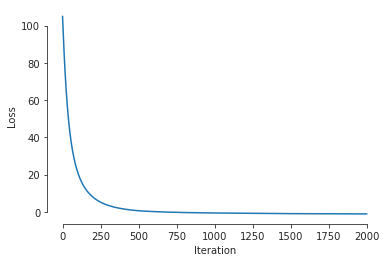

In [5]:
train(mctm, y)

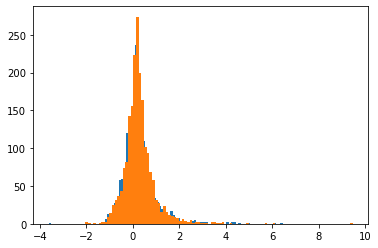

In [6]:
z, log_d = mctm.forward(y)
plt.hist(z[:,0].detach().numpy(), bins=100)
plt.hist(z[:,1].detach().numpy(), bins=100)
plt.show()

In [7]:
polynomial_range = torch.FloatTensor([[-10, -10],
                                          [10, 10]])
mctm.approximate_inverse(y, polynomial_range= torch.FloatTensor([-7,-7]), max_val=torch.FloatTensor([7,7]))
# use cubic splines for approx?

TypeError: approximate_inverse() got an unexpected keyword argument 'min_val'

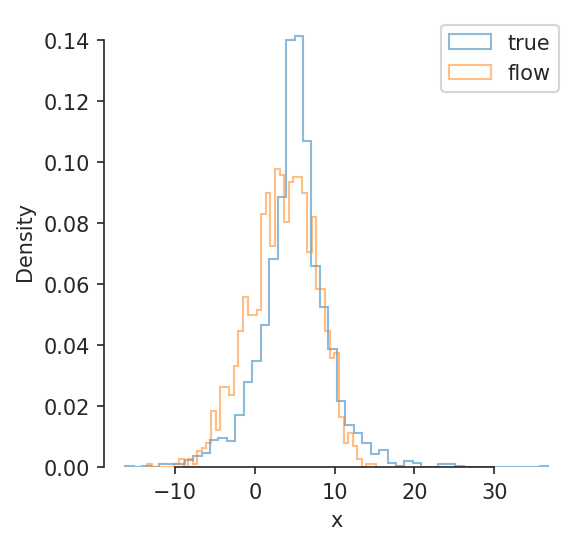

In [8]:
evaluate(mctm)

In [10]:
def multivariable_lambda_prediction(input, degree, number_variables, params, min_val, max_val):

    #steps
    output = input.clone()
    # loop over all variables
    params_index = 1
    for var_num in range(number_variables):
        # loop over all before variables
        for covar_num in range(var_num-1):

            min_val = torch.min(input[:,covar_num])
            max_val = torch.max(input[:,covar_num])

            # compute lambda fct value using before variable
            lambda_value = bernstein_prediction(params[:, params_index], input[:,covar_num], degree, min_val, max_val, monotonically_increasing=False, derivativ=0)

            # update
            # Cloning issue?
            output[:,var_num] += lambda_value * input[:,covar_num]

            params_index += 1

    return output

def inv_multivariable_lambda_prediction(input, degree, number_variables, params, min_val, max_val):
    return 2

class Decorrelation(nn.Module):
    def __init__(self, degree, number_variables):
        super().__init__()
        self.degree  = degree
        self.number_variables = number_variables
        self.num_lambdas = number_variables * (number_variables-1) / 2 - number_variables
        self.params = nn.Parameter(torch.reshape(p,(self.degree+1, self.num_lambdas)))

    def forward(self, input, log_d = 0, inverse = False):
        if not inverse:
            z     = multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, min_val, max_val)
        else:
            z     = inv_multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, min_val, max_val)
        return z, log_d

    def __repr__(self):
        return "Affine(alpha={alpha:.2f}, beta={beta:.2f})".format(alpha = self.alpha[0], beta = self.beta[0])